# Code Review 10
Review of apf2139

### Review Questions
I tested their code and everything ran fine. They used np.random to generate data and sampled data from a Poisson distribution. A Poisson distribution geneartes a discrete probability distribution.

Apf2139 used a switchpoint model with pymc3 like we did in class, and did not link to the tutorial. They are trying to fit the early and late rates of change of Frank Sinatra's level of goodness using this model. The model samples data from a Discrete Uniform and Exponential distribution, rather than a Poisson distribution.

I agree with their assessment of the model fit; the model worked well and correctly estimated the switchpoint and early and rate lates. I also tried using 35 as the switchpoint, as they talked about doing, and the switchpoint was predicted incorrectly where the true switchpoint was not in the 95% HPD range. I would further investigate why this might be happening and how to optimize the model for correctly estimating different switchpoints. I wonder if this is because two of the five NaN values are at 32 and 33, which are very close to the actual switchpoint and may skew the data slightly.


In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/juliazeh/miniconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [23]:
# fix a random seed
np.random.seed(7)

# generate data
data = pd.DataFrame({
    "Frank_Sinatras_age": np.arange(0, 82),
    "Level_of_subjective_goodness_that_year": np.concatenate([
        np.random.poisson(10.0, 35),
        np.random.poisson(1.0, 47),
    ])
})

# introduce some random NaN values (pymc3 will handle these)
missing = np.random.randint(0, data.shape[0], 5)
data.loc[missing, "Level_of_subjective_goodness_that_year"] = np.nan

data[30:50]

,Frank_Sinatras_age,Level_of_subjective_goodness_that_year
30,30,8.0
31,31,12.0
32,32,NaN
33,33,NaN
34,34,6.0
35,35,1.0
36,36,2.0
37,37,4.0
38,38,0.0
39,39,1.0


In [11]:
# plot the generated data
toyplot.scatterplot(
    data.Frank_Sinatras_age,
    data.Level_of_subjective_goodness_that_year, 
    width=450, 
    height=300,
    size=8, 
    opacity=0.5,
    xlabel="age", 
    ylabel="goodness",
);


0 25 50 75 age 0 5 10 15 goodness

In [12]:
with pm.Model() as goodness_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.Frank_Sinatras_age.min(), 
        upper=data.Frank_Sinatras_age.max(), 
        testval=40)

    # Priors for pre- and post-switch rates
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.Frank_Sinatras_age, early_rate, late_rate)

    goodness = pm.Poisson('goodness', rate, observed=data.Level_of_subjective_goodness_that_year)

In [19]:
with goodness_model:
    trace = pm.sample(100000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [goodness_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate_log__, early_rate_log__]
 98%|█████████▊| 98354/100500 [01:40<00:02, 979.47it/s]/Users/juliazeh/miniconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|█████████▉| 100457/100500 [01:42<00:00, 981.23it/s]/Users/juliazeh/miniconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 100500/100500 [01:42<00:00, 981.17it/s]
Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the whole trace.
The number of effective samples is smaller than 10% for some parameters.


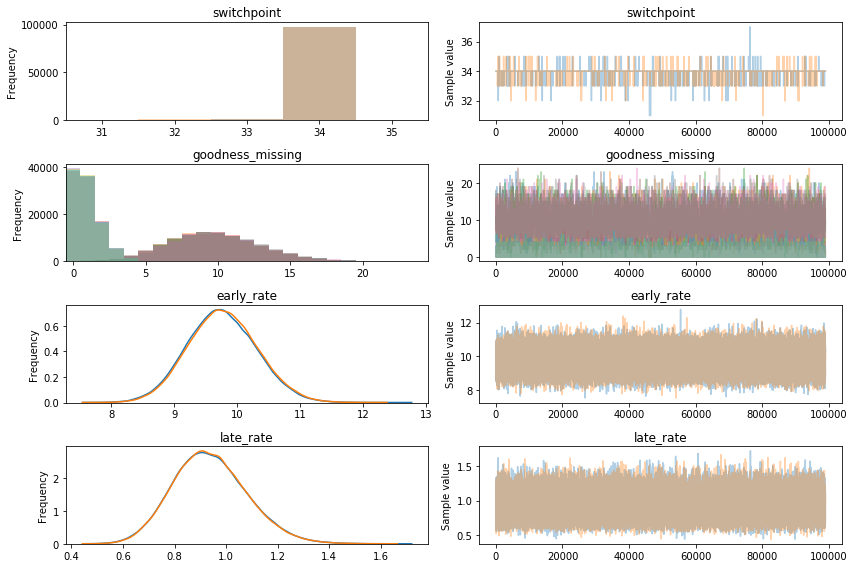

In [20]:
pm.traceplot(trace[1000:]);

In [21]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
switchpoint,33.977660,0.221542,0.006725,34.000000,34.000000,827.0,1.000144
goodness_missing__0,9.726230,3.228071,0.064805,3.000000,15.000000,2415.0,1.000026
goodness_missing__1,9.745630,3.173540,0.065314,3.000000,15.000000,2386.0,1.001516
goodness_missing__2,9.760135,3.275190,0.069471,4.000000,16.000000,2245.0,1.000731
goodness_missing__3,0.944995,0.979719,0.007886,0.000000,3.000000,15621.0,1.000128
goodness_missing__4,0.939010,0.982049,0.006984,0.000000,3.000000,16164.0,1.000081
early_rate,9.760762,0.546265,0.003450,8.693179,10.826082,23872.0,1.000157
late_rate,0.936405,0.143262,0.000487,0.664418,1.220749,89655.0,0.999996
